# Australian Steam Recommendation Prediction – Data Preparation

This notebook builds a **training dataset** for a binary recommendation prediction task using ONLY the Australian Steam datasets (strategy A):

- `./data/australian_user_review.json` – users and their reviews, including a `recommend` label
- `./data/australian_user_data.json` – user libraries and playtime per game
- `./data/steam_games.json` – game metadata (genres, tags, price, metascore, etc.)

The goal is to construct a flattened table where **each row is a single review** with:

- `user_id`, `item_id`
- `review_text`
- `label` (1 if recommended, 0 otherwise)
- user–item features (e.g., `playtime_forever`, `playtime_2weeks`)
- game features (e.g., `app_name`, `genres`, `tags`, `price`, `metascore`)

You can then use this merged dataset for EDA and model training in later sections of your assignment notebook.

In [5]:
# Standard imports
import json
from pathlib import Path

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_columns', None)
pd.set_option('display.width', 180)

print('Libraries imported.')

Libraries imported.


## 1. Utility: Robust JSON Loader

The Australian datasets may be stored either as:
- a single JSON list of objects, or
- JSON lines (one JSON object per line).

The helper below tries `json.load()` first (single JSON file). If that fails, it falls back to JSON-lines mode.

In [6]:
import ast
from pathlib import Path
def load_python_dict_lines(path: Path):
    """
    Load a file where each line is a Python dict literal, e.g.
    {'user_id': '...', 'reviews': [...]}

    Returns a list of dicts.
    """
    if not path.exists():
        raise FileNotFoundError(f"File not found: {path}")
    
    objs = []
    with path.open("r", encoding="utf-8") as f:
        for line in f:
            line = line.strip()
            if not line:
                continue
            try:
                obj = ast.literal_eval(line)  # <-- this can parse single-quote Python dicts
                objs.append(obj)
            except Exception as e:
                # If there's a malformed line, skip it
                # print("Failed to parse line:", line[:100], "error:", e)
                continue
    return objs

data_dir = Path('./data')
print('Data directory:', data_dir.resolve())

Data directory: /home/dorohaze/Documents/258proj/data


## 2. Load and Flatten `australian_user_review.json`

Each top-level object is expected to represent a user and contain a `reviews` list. We flatten this so that
each **row is a single review** with `user_id`, `item_id`, `review_text`, and a binary `recommend` label.

In [7]:
reviews_path = data_dir / 'australian_user_reviews.json'
reviews_raw = load_python_dict_lines(reviews_path)
print(f'Loaded {len(reviews_raw)} user entries from', reviews_path)

flat_reviews = []
for user_obj in reviews_raw:
    user_id = user_obj.get('user_id')
    user_url = user_obj.get('user_url')
    reviews_list = user_obj.get('reviews', [])
    for r in reviews_list:
        flat_reviews.append({
            'user_id': user_id,
            'user_url': user_url,
            'item_id': r.get('item_id'),
            'review_text': r.get('review'),
            'recommend_raw': r.get('recommend'),
            'funny': r.get('funny'),
            'helpful': r.get('helpful'),
            'posted': r.get('posted'),
            'last_edited': r.get('last_edited'),
        })

df_reviews = pd.DataFrame(flat_reviews)
print('Flattened reviews shape:', df_reviews.shape)
display(df_reviews.head())

Loaded 25799 user entries from data/australian_user_reviews.json
Flattened reviews shape: (59305, 9)


,user_id,user_url,item_id,review_text,recommend_raw,funny,helpful,posted,last_edited
0,76561197970982479,http://steamcommunity.com/profiles/76561197970...,1250,Simple yet with great replayability. In my opi...,True,,No ratings yet,"Posted November 5, 2011.",
1,76561197970982479,http://steamcommunity.com/profiles/76561197970...,22200,It's unique and worth a playthrough.,True,,No ratings yet,"Posted July 15, 2011.",
2,76561197970982479,http://steamcommunity.com/profiles/76561197970...,43110,Great atmosphere. The gunplay can be a bit chu...,True,,No ratings yet,"Posted April 21, 2011.",
3,js41637,http://steamcommunity.com/id/js41637,251610,I know what you think when you see this title ...,True,,15 of 20 people (75%) found this review helpful,"Posted June 24, 2014.",
4,js41637,http://steamcommunity.com/id/js41637,227300,For a simple (it's actually not all that simpl...,True,,0 of 1 people (0%) found this review helpful,"Posted September 8, 2013.",


### Normalize Recommendation Label

We convert the `recommend_raw` field (typically `True`/`False`) into an integer `label` column:
- `label = 1` if the user recommends the game
- `label = 0` otherwise

We also drop rows where the review text is missing.

In [8]:
flat_reviews[0]

{'user_id': '76561197970982479',
 'user_url': 'http://steamcommunity.com/profiles/76561197970982479',
 'item_id': '1250',
 'review_text': 'Simple yet with great replayability. In my opinion does "zombie" hordes and team work better than left 4 dead plus has a global leveling system. Alot of down to earth "zombie" splattering fun for the whole family. Amazed this sort of FPS is so rare.',
 'recommend_raw': True,
 'funny': '',
 'helpful': 'No ratings yet',
 'posted': 'Posted November 5, 2011.',
 'last_edited': ''}

In [9]:
# Drop rows with missing review text
df_reviews = df_reviews[df_reviews['review_text'].notnull()].copy()

# Normalize recommend field to integer label
if df_reviews['recommend_raw'].dtype == bool:
    df_reviews['label'] = df_reviews['recommend_raw'].astype(int)
else:
    # If not boolean, try to coerce to 0/1
    df_reviews['label'] = df_reviews['recommend_raw'].astype(int)

print('Label distribution:')
print(df_reviews['label'].value_counts(dropna=False))
display(df_reviews[['user_id', 'item_id', 'review_text', 'label']].head())

Label distribution:
label
1    52473
0     6832
Name: count, dtype: int64


,user_id,item_id,review_text,label
0,76561197970982479,1250,Simple yet with great replayability. In my opi...,1
1,76561197970982479,22200,It's unique and worth a playthrough.,1
2,76561197970982479,43110,Great atmosphere. The gunplay can be a bit chu...,1
3,js41637,251610,I know what you think when you see this title ...,1
4,js41637,227300,For a simple (it's actually not all that simpl...,1


## 3. Load and Flatten `australian_user_data.json`

This file contains, for each user, their owned items and playtime statistics. We flatten it so that each row is a
single **(user, item)** pair with `playtime_forever` and `playtime_2weeks`. This can then be joined to the reviews.

In [10]:
user_data_path = data_dir / 'australian_users_items.json'
user_data_raw = load_python_dict_lines(user_data_path)
print(f'Loaded {len(user_data_raw)} user entries from', user_data_path)

flat_user_items = []
for user_obj in user_data_raw:
    user_id = user_obj.get('user_id') or user_obj.get('steam_id')
    items_count = user_obj.get('items_count')
    items = user_obj.get('items', [])
    for it in items:
        flat_user_items.append({
            'user_id': user_id,
            'items_count': items_count,
            'item_id': it.get('item_id'),
            'item_name': it.get('item_name'),
            'playtime_forever': it.get('playtime_forever'),
            'playtime_2weeks': it.get('playtime_2weeks'),
        })

df_user_items = pd.DataFrame(flat_user_items)
print('Flattened user-item shape:', df_user_items.shape)
display(df_user_items.head())

Loaded 88310 user entries from data/australian_users_items.json
Flattened user-item shape: (5153209, 6)


,user_id,items_count,item_id,item_name,playtime_forever,playtime_2weeks
0,76561197970982479,277,10,Counter-Strike,6,0
1,76561197970982479,277,20,Team Fortress Classic,0,0
2,76561197970982479,277,30,Day of Defeat,7,0
3,76561197970982479,277,40,Deathmatch Classic,0,0
4,76561197970982479,277,50,Half-Life: Opposing Force,0,0


## 4. Load `steam_games.json` (Game Metadata)

We load the game metadata, which includes features like `app_name`, `genres`, `tags`, `price`, `metascore`, etc.
We normalize the primary key to `item_id` so it can be joined with the review and user–item tables.

In [11]:
games_path = data_dir / 'steam_games.json'
games_raw = load_python_dict_lines(games_path)
print(f'Loaded {len(games_raw)} game entries from', games_path)

df_games = pd.DataFrame(games_raw)
print('Raw games shape:', df_games.shape)
display(df_games.head())

# Normalize item_id column
id_col = None
for cand in ['id', 'app_id', 'item_id', 'appid']:
    if cand in df_games.columns:
        id_col = cand
        break

if id_col is None:
    raise KeyError('Could not find an id/app_id/item_id column in steam_games.json')

df_games['item_id'] = df_games[id_col].astype(str)
print('Using games ID column:', id_col)

game_feature_cols = ['item_id']
for c in ['app_name', 'title', 'genres', 'tags', 'price', 'metascore', 'sentiment', 'early_access', 'developer', 'publisher', 'release_date']:
    if c in df_games.columns:
        game_feature_cols.append(c)

df_games_small = df_games[game_feature_cols].copy()
print('Selected game feature columns:', game_feature_cols)
display(df_games_small.head())

Loaded 32135 game entries from data/steam_games.json
Raw games shape: (32135, 16)


,publisher,genres,app_name,title,url,release_date,tags,discount_price,reviews_url,specs,price,early_access,id,developer,sentiment,metascore
0,Kotoshiro,"[Action, Casual, Indie, Simulation, Strategy]",Lost Summoner Kitty,Lost Summoner Kitty,http://store.steampowered.com/app/761140/Lost_...,2018-01-04,"[Strategy, Action, Indie, Casual, Simulation]",4.49,http://steamcommunity.com/app/761140/reviews/?...,[Single-player],4.99,False,761140,Kotoshiro,NaN,NaN
1,"Making Fun, Inc.","[Free to Play, Indie, RPG, Strategy]",Ironbound,Ironbound,http://store.steampowered.com/app/643980/Ironb...,2018-01-04,"[Free to Play, Strategy, Indie, RPG, Card Game...",NaN,http://steamcommunity.com/app/643980/reviews/?...,"[Single-player, Multi-player, Online Multi-Pla...",Free To Play,False,643980,Secret Level SRL,Mostly Positive,NaN
2,Poolians.com,"[Casual, Free to Play, Indie, Simulation, Sports]",Real Pool 3D - Poolians,Real Pool 3D - Poolians,http://store.steampowered.com/app/670290/Real_...,2017-07-24,"[Free to Play, Simulation, Sports, Casual, Ind...",NaN,http://steamcommunity.com/app/670290/reviews/?...,"[Single-player, Multi-player, Online Multi-Pla...",Free to Play,False,670290,Poolians.com,Mostly Positive,NaN
3,彼岸领域,"[Action, Adventure, Casual]",弹炸人2222,弹炸人2222,http://store.steampowered.com/app/767400/2222/,2017-12-07,"[Action, Adventure, Casual]",0.83,http://steamcommunity.com/app/767400/reviews/?...,[Single-player],0.99,False,767400,彼岸领域,NaN,NaN
4,NaN,NaN,Log Challenge,NaN,http://store.steampowered.com/app/773570/Log_C...,NaN,"[Action, Indie, Casual, Sports]",1.79,http://steamcommunity.com/app/773570/reviews/?...,"[Single-player, Full controller support, HTC V...",2.99,False,773570,NaN,NaN,NaN


Using games ID column: id
Selected game feature columns: ['item_id', 'app_name', 'title', 'genres', 'tags', 'price', 'metascore', 'sentiment', 'early_access', 'developer', 'publisher', 'release_date']


,item_id,app_name,title,genres,tags,price,metascore,sentiment,early_access,developer,publisher,release_date
0,761140,Lost Summoner Kitty,Lost Summoner Kitty,"[Action, Casual, Indie, Simulation, Strategy]","[Strategy, Action, Indie, Casual, Simulation]",4.99,NaN,NaN,False,Kotoshiro,Kotoshiro,2018-01-04
1,643980,Ironbound,Ironbound,"[Free to Play, Indie, RPG, Strategy]","[Free to Play, Strategy, Indie, RPG, Card Game...",Free To Play,NaN,Mostly Positive,False,Secret Level SRL,"Making Fun, Inc.",2018-01-04
2,670290,Real Pool 3D - Poolians,Real Pool 3D - Poolians,"[Casual, Free to Play, Indie, Simulation, Sports]","[Free to Play, Simulation, Sports, Casual, Ind...",Free to Play,NaN,Mostly Positive,False,Poolians.com,Poolians.com,2017-07-24
3,767400,弹炸人2222,弹炸人2222,"[Action, Adventure, Casual]","[Action, Adventure, Casual]",0.99,NaN,NaN,False,彼岸领域,彼岸领域,2017-12-07
4,773570,Log Challenge,NaN,NaN,"[Action, Indie, Casual, Sports]",2.99,NaN,NaN,False,NaN,NaN,NaN


## 5. Merge Reviews, User–Item Data, and Game Metadata

We now create a single DataFrame by performing the following joins:

1. **Reviews + User–Item** on `['user_id', 'item_id']` (left join from reviews)
2. **(Reviews + User–Item) + Games** on `['item_id']` (left join)

The result is a table where each row is a single review with:
- `review_text`, `label`
- user–item behavior features (`playtime_forever`, `playtime_2weeks`, `items_count`)
- game metadata (`price`, `genres`, `tags`, etc.).

In [12]:
# Ensure item_id/user_id are strings for consistent joins
df_reviews['item_id'] = df_reviews['item_id'].astype(str)
df_user_items['item_id'] = df_user_items['item_id'].astype(str)
df_user_items['user_id'] = df_user_items['user_id'].astype(str)
df_reviews['user_id'] = df_reviews['user_id'].astype(str)

# Join reviews with user-item playtime
df_merged = df_reviews.merge(
    df_user_items[['user_id', 'item_id', 'items_count', 'item_name', 'playtime_forever', 'playtime_2weeks']],
    on=['user_id', 'item_id'], how='left'
)
print('After merging user-item data:', df_merged.shape)

# Join with game metadata
df_merged = df_merged.merge(df_games_small, on='item_id', how='left')
print('After merging game metadata:', df_merged.shape)

display(df_merged.head())

After merging user-item data: (60732, 14)
After merging game metadata: (60732, 25)


,user_id,user_url,item_id,review_text,recommend_raw,funny,helpful,posted,last_edited,label,items_count,item_name,playtime_forever,playtime_2weeks,app_name,title,genres,tags,price,metascore,sentiment,early_access,developer,publisher,release_date
0,76561197970982479,http://steamcommunity.com/profiles/76561197970...,1250,Simple yet with great replayability. In my opi...,True,,No ratings yet,"Posted November 5, 2011.",,1,277.0,Killing Floor,10006.0,0.0,Killing Floor,Killing Floor,[Action],"[FPS, Zombies, Co-op, Survival, Action, Multip...",19.99,72,Overwhelmingly Positive,False,Tripwire Interactive,Tripwire Interactive,2009-05-14
1,76561197970982479,http://steamcommunity.com/profiles/76561197970...,22200,It's unique and worth a playthrough.,True,,No ratings yet,"Posted July 15, 2011.",,1,277.0,Zeno Clash,271.0,0.0,Zeno Clash,Zeno Clash,"[Action, Indie]","[Action, Indie, Surreal, Beat 'em up, FPS, Fig...",9.99,77,Very Positive,False,ACE Team,ACE Team,2009-04-21
2,76561197970982479,http://steamcommunity.com/profiles/76561197970...,43110,Great atmosphere. The gunplay can be a bit chu...,True,,No ratings yet,"Posted April 21, 2011.",,1,277.0,Metro 2033,834.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,js41637,http://steamcommunity.com/id/js41637,251610,I know what you think when you see this title ...,True,,15 of 20 people (75%) found this review helpful,"Posted June 24, 2014.",,1,888.0,Barbie™ Dreamhouse Party™,84.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,js41637,http://steamcommunity.com/id/js41637,227300,For a simple (it's actually not all that simpl...,True,,0 of 1 people (0%) found this review helpful,"Posted September 8, 2013.",,1,888.0,Euro Truck Simulator 2,551.0,0.0,Euro Truck Simulator 2,Euro Truck Simulator 2,"[Indie, Simulation]","[Simulation, Driving, Open World, Realistic, R...",19.99,79,Overwhelmingly Positive,False,SCS Software,SCS Software,2013-01-16


## 6. Basic Sanity Checks

We inspect label distribution and some key numeric fields (e.g., `playtime_forever`) to ensure the merged
dataset looks reasonable. This is a good starting point for more detailed EDA and modeling.

Final merged columns:
['user_id', 'user_url', 'item_id', 'review_text', 'recommend_raw', 'funny', 'helpful', 'posted', 'last_edited', 'label', 'items_count', 'item_name', 'playtime_forever', 'playtime_2weeks', 'app_name', 'title', 'genres', 'tags', 'price', 'metascore', 'sentiment', 'early_access', 'developer', 'publisher', 'release_date']

Label distribution:
label
1    53748
0     6984
Name: count, dtype: int64


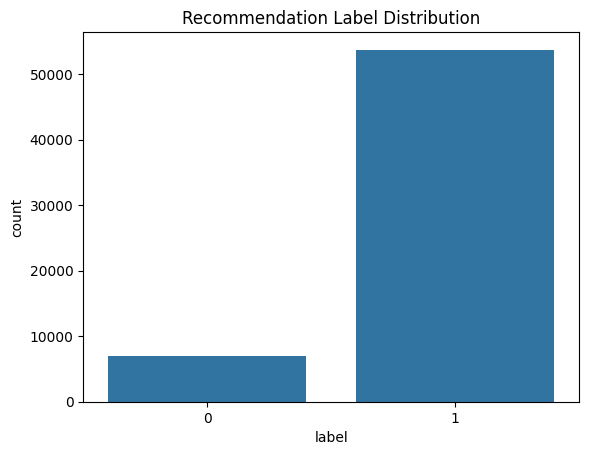

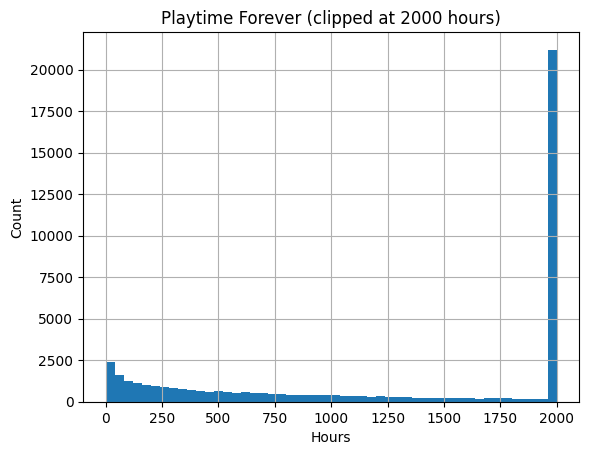

In [13]:
print('Final merged columns:')
print(df_merged.columns.tolist())

print('\nLabel distribution:')
print(df_merged['label'].value_counts(dropna=False))

# Plot label distribution
sns.countplot(data=df_merged, x='label')
plt.title('Recommendation Label Distribution')
plt.show()

# If playtime is available, inspect its distribution
if 'playtime_forever' in df_merged.columns:
    plt.figure()
    df_merged['playtime_forever'].dropna().clip(upper=2000).hist(bins=50)
    plt.title('Playtime Forever (clipped at 2000 hours)')
    plt.xlabel('Hours')
    plt.ylabel('Count')
    plt.show()

## 7. Save Merged Dataset

To make future experiments faster, we save the merged dataset to disk as a CSV file. You can alternatively
save to Parquet for better performance with large data.

In [14]:
output_path = Path('australian_steam_merged.csv')
df_merged.to_csv(output_path, index=False)
print('Saved merged dataset to:', output_path.resolve())

Saved merged dataset to: /home/dorohaze/Documents/258proj/australian_steam_merged.csv


In [15]:

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
# Drop missing
df = df_merged.dropna(subset=["review_text", "label"]).copy()

X_text = df["review_text"].astype(str)
y = df["label"].astype(int)

# 80/20 split is typical for assignment
X_train, X_test, y_train, y_test = train_test_split(
    X_text, y, test_size=0.2, random_state=42, stratify=y
)

print("Train size:", len(X_train))
print("Test size:", len(X_test))



majority_class = y_train.mode()[0]
y_pred_majority = np.full_like(y_test, fill_value=majority_class)

acc_majority = accuracy_score(y_test, y_pred_majority)
f1_majority = f1_score(y_test, y_pred_majority)

print("Majority baseline:")
print("  Accuracy:", acc_majority)
print("  F1:", f1_majority)
f1_macro = f1_score(y_test, y_pred_majority, average="macro")
print("Macro F1:", f1_macro)

Train size: 48585
Test size: 12147
Majority baseline:
  Accuracy: 0.8849921791388821
  F1: 0.938987640302223
Macro F1: 0.4694938201511115


In [16]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score

# TF-IDF vectorizer
tfidf = TfidfVectorizer(
    max_features=50000,
    ngram_range=(1,2),
    min_df=3,
)

X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

nb = MultinomialNB()
nb.fit(X_train_tfidf, y_train)

y_pred_nb = nb.predict(X_test_tfidf)
y_prob_nb = nb.predict_proba(X_test_tfidf)[:,1]

print("Naive Bayes:")
print("  Accuracy:", accuracy_score(y_test, y_pred_nb))
print("  F1:", f1_score(y_test, y_pred_nb))
f1_macro = f1_score(y_test, y_pred_nb, average="macro")
print("Macro F1:", f1_macro)



Naive Bayes:
  Accuracy: 0.8885321478554375
  F1: 0.9406868757666024
Macro F1: 0.508542619329413


In [17]:
# Drop rows with missing text or label
df = df_merged.dropna(subset=['review_text', 'label']).copy()
df['review_text'] = df['review_text'].astype(str)
df['label'] = df['label'].astype(int)

print('After cleaning:', df.shape)
print('Label distribution:')
print(df['label'].value_counts(normalize=True))

X_text = df['review_text']
y = df['label']



X_train, X_test, y_train, y_test = train_test_split(
    X_text, y,
    test_size=0.2,
    random_state=42,
    stratify=y,
)

print('Train size:', len(X_train))
print('Test size:', len(X_test))

After cleaning: (60732, 25)
Label distribution:
label
1    0.885003
0    0.114997
Name: proportion, dtype: float64
Train size: 48585
Test size: 12147


In [18]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression

# 1. Identify numeric feature columns that exist
candidate_num_cols = ['playtime_forever', 'playtime_2weeks', 'items_count', 'price', 'metascore']
num_cols = [c for c in candidate_num_cols if c in df.columns]
print("Base numeric feature columns:", num_cols)

# 2. Special cleaning for price (handles strings like 'Free to Play', '$9.99', etc.)
if 'price' in df.columns:
    def clean_price(x):
        if isinstance(x, str):
            x_low = x.lower()
            if 'free' in x_low:
                return 0.0
            x = x.replace('$', '')
            try:
                return float(x)
            except:
                return np.nan
        return x
    df['price'] = df['price'].apply(clean_price)

# 3. Convert ALL numeric columns to real numbers, coercing any strings ('NA', etc.) to NaN
for col in num_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# 4. Optional: add log-transformed versions for skewed features
for col in ['playtime_forever', 'playtime_2weeks']:
    if col in df.columns:
        log_col = 'log_' + col
        df[log_col] = np.log1p(df[col])
        num_cols.append(log_col)

print("Final numeric feature columns:", num_cols)

# 5. Fill any remaining NaNs with 0
df[num_cols] = df[num_cols].fillna(0)

# 6. Now align with train/test
X_train_num = df.loc[X_train.index, num_cols].values
X_test_num  = df.loc[X_test.index,  num_cols].values

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_num_scaled = scaler.fit_transform(X_train_num)
X_test_num_scaled  = scaler.transform(X_test_num)
print('Numeric train shape:', X_train_num_scaled.shape)
print('Numeric test shape:', X_test_num_scaled.shape)

from scipy.sparse import hstack

# Combine TF-IDF (sparse) and numeric (dense) features
X_train_full = hstack([X_train_tfidf, X_train_num_scaled])
X_test_full = hstack([X_test_tfidf, X_test_num_scaled])

print('Combined train shape:', X_train_full.shape)
print('Combined test shape:', X_test_full.shape)

# Train logistic regression on combined features
clf_full = LogisticRegression(max_iter=2000, n_jobs=-1)
clf_full.fit(X_train_full, y_train)

y_pred_full = clf_full.predict(X_test_full)
y_prob_full = clf_full.predict_proba(X_test_full)[:, 1]

acc_full = accuracy_score(y_test, y_pred_full)
f1_full = f1_score(y_test, y_pred_full)
f1_macro_full = f1_score(y_test, y_pred_full, average='macro')
roc_full = roc_auc_score(y_test, y_prob_full)

print('Stronger model (TF-IDF + numeric features):')
print('  Accuracy   :', acc_full)
print('  F1 (pos)   :', f1_full)
print('  F1 macro   :', f1_macro_full)
print('  ROC-AUC    :', roc_full)


Base numeric feature columns: ['playtime_forever', 'playtime_2weeks', 'items_count', 'price', 'metascore']
Final numeric feature columns: ['playtime_forever', 'playtime_2weeks', 'items_count', 'price', 'metascore', 'log_playtime_forever', 'log_playtime_2weeks']
Numeric train shape: (48585, 7)
Numeric test shape: (12147, 7)
Combined train shape: (48585, 50007)
Combined test shape: (12147, 50007)
Stronger model (TF-IDF + numeric features):
  Accuracy   : 0.9158639993414012
  F1 (pos)   : 0.9543138131426017
  F1 macro   : 0.7115643909787852
  ROC-AUC    : 0.9149755123104326


In [20]:
from lightgbm import LGBMClassifier # type: ignore
from scipy.sparse import hstack

# Combine TF-IDF + numeric features
X_train_full = hstack([X_train_tfidf, X_train_num_scaled])
X_test_full = hstack([X_test_tfidf, X_test_num_scaled])

# Class imbalance handling
pos_weight = y_train.value_counts()[0] / y_train.value_counts()[1]

clf_lgbm = LGBMClassifier(
    n_estimators=500,
    learning_rate=0.05,
    num_leaves=63,
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight=pos_weight,
    n_jobs=-1
)

clf_lgbm.fit(X_train_full, y_train)

y_prob_lgbm = clf_lgbm.predict_proba(X_test_full)[:, 1]
y_pred_lgbm = (y_prob_lgbm >= 0.5).astype(int)

print("LightGBM:")
print("  Accuracy   :", accuracy_score(y_test, y_pred_lgbm))
print("  F1 (pos)   :", f1_score(y_test, y_pred_lgbm))
print("  F1 macro   :", f1_score(y_test, y_pred_lgbm, average='macro'))
print("  ROC-AUC    :", roc_auc_score(y_test, y_prob_lgbm))

[LightGBM] [Info] Number of positive: 42998, number of negative: 5587
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.854763 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 438337
[LightGBM] [Info] Number of data points in the train set: 48585, number of used features: 13676
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.885006 -> initscore=2.040711
[LightGBM] [Info] Start training from score 2.040711
LightGBM:
  Accuracy   : 0.8957767349962954
  F1 (pos)   : 0.939948771463808
  F1 macro   : 0.7729009112611692
  ROC-AUC    : 0.9143919362088194


/home/dorohaze/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/dorohaze/lib/python3.12/site-packages/lightgbm/basic.py:1238: UserWarning: Converting data to scipy sparse matrix.
  _log_warning("Converting data to scipy sparse matrix.")


In [23]:
###!pip install transformers datasets accelerate sentencepiece
from datasets import Dataset

train_ds = Dataset.from_dict({"text": X_train.tolist(), "label": y_train.tolist()})
test_ds  = Dataset.from_dict({"text": X_test.tolist(),  "label": y_test.tolist()})

from transformers import DistilBertTokenizerFast

tokenizer = DistilBertTokenizerFast.from_pretrained("distilbert-base-uncased")

def tokenize(batch):
    return tokenizer(batch["text"], truncation=True, padding="max_length", max_length=160)

train_ds = train_ds.map(tokenize, batched=True)
test_ds  = test_ds.map(tokenize,  batched=True)

from transformers import DistilBertForSequenceClassification

model = DistilBertForSequenceClassification.from_pretrained(
    "distilbert-base-uncased",
    num_labels=2
)

from transformers import TrainingArguments, Trainer
import numpy as np
from sklearn.metrics import f1_score, accuracy_score, roc_auc_score

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    probs = np.argmax(logits, axis=-1)
    return {
        "accuracy": accuracy_score(labels, probs),
        "f1_macro": f1_score(labels, probs, average="macro"),
    }
training_args = TrainingArguments(
    output_dir="./bert_steam",
    do_train=True,
    do_eval=True,
    num_train_epochs=2,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    learning_rate=2e-5,
    weight_decay=0.01,
    logging_steps=100,
    save_steps=1000,   # how often to save/eval in older versions
)

trainer = Trainer(
    model=model,
    args=training_args, 
    train_dataset=train_ds,
    eval_dataset=test_ds,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)


trainer.train()


import torch
from sklearn.metrics import roc_auc_score

pred_logits = trainer.predict(test_ds).predictions
prob_1 = torch.softmax(torch.tensor(pred_logits), dim=1)[:,1].numpy()

roc_auc = roc_auc_score(y_test, prob_1)
print("ROC-AUC:", roc_auc)

Map: 100%|██████████| 12147/12147 [00:00<00:00, 35033.46 examples/s]
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipykernel_11367/3080546686.py:48: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
100,0.346600
200,0.252300
300,0.255400
400,0.254300
500,0.246600
600,0.211200
700,0.234100
800,0.240300
900,0.231300
1000,0.212500


ROC-AUC: 0.9362123154267449


In [24]:
import numpy as np
import torch
from sklearn.metrics import f1_score, accuracy_score, roc_auc_score

# Logits from trainer.predict(test_ds)
# pred_logits = trainer.predict(test_ds).predictions

# Predicted labels
y_pred = np.argmax(pred_logits, axis=1)

# Metrics
accuracy = accuracy_score(y_test, y_pred)
f1_pos = f1_score(y_test, y_pred)
f1_macro = f1_score(y_test, y_pred, average="macro")

# ROC-AUC
prob_1 = torch.softmax(torch.tensor(pred_logits), dim=1).numpy()[:, 1]
roc_auc = roc_auc_score(y_test, prob_1)

print("Accuracy:", accuracy)
print("F1 positive:", f1_pos)
print("F1 macro:", f1_macro)
print("ROC-AUC:", roc_auc)



Accuracy: 0.9317526961389644
F1 positive: 0.9619323139091702
F1 macro: 0.8162859821433018
ROC-AUC: 0.9362123154267449
